# FLFM Forward and Backward Projector Generator
__Requirements__
- Dependencies
    - OpenCV, Numpy, Torch, Matplotlib, gc
- Required Information
    - Camera related information
    - A image of the lenslets (or a image that shows the outlines.)
    
__Warning__
- The methods used in the following code may generate inaccruate results. Consider using experimentally measured PSFs.

In [4]:
import cv2 as cv
import numpy as np
import torch
import matplotlib.pyplot as plt
import gc
import torchvision.transforms as transforms

In [5]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

# 0. Camera Information
(In the future, this will be done by reading a .txt or a .csv file)

In [6]:
# Set-up Specific Constants
NA = 0.4
fobj = 10000
f1 = 1
f2 = 1
fm = np.array([47000])

mla2sensor = 47000 # microns
lenspitch = 2520 # Lens pitch in microns 
pixel_size = 3.54 # Also referred to as pixel pitch in microns/px
refractive_index = 1 # Refractive index of the medium
wavelength = 0.5530

noLensHoriz = 3
noLensVert = 3

spacingPixels = 777

In [7]:
def FLFM_setCameraParams(config):
    # Config should be an array with the following parameters:
    # [NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot]
    
    objRad = config[0] * config[1] # Objective radius = NA * fobj
    k = 2 * np.pi * config[9] / config[8] # k = 2 * pi * refractive_index / wavelength (wave number)
    M = (config[4] * config[3]) / (config[2] * config[1]) # Magnification = fm * f2 / (f1 * fobj)
    d_refract = 3.5e-3 # Index of Refraction (__Don't know wherer the number came from__)
    fsRad = config[6] * config[3] / (2 * config[4]) # Field stop radius = lenspitch * f2 / (2 * fm)
    fovRad = fsRad / config[2]
    return [objRad, k, M, d_refract, fsRad, fovRad]

# Example: camera_params = FLFM_setCameraParams(config)

In [8]:
def resolution(camera_params, depth_step):
    # Find the number of pixels behind a lesnlet
    lenslet_pixels = [len(perspectives[0,0,0,:]), len(perspectives[0,0,:,0])]
    # Corresponding sensor resolution
    sensor_res = pixel_size
    object_res = [pixel_size/camera_params[2], pixel_size/camera_params[2], depth_step] # config[2] is the magnification
    fovRadVox = (camera_params[5] / i for i in object_res)  # Field of view radius in voxels
    return [lenslet_pixels, sensor_res, object_res, fovRadVox]

# example: res = resolution(camera_params, 10)

# 1. Hough Transform for Circle Detection 
(Do not need to do everytime unless mask has changed for some ungodly reason.)

In [9]:
mask_img = cv.imread(r'./test_images/img_pdh_contrast.tif', cv.IMREAD_GRAYSCALE)
min_radius = int(len(mask_img[0,:])/12)

In [10]:
frames = cv.imread(r'./test_images/img_pdh.png', cv.IMREAD_GRAYSCALE)
frames = torch.from_numpy(frames).unsqueeze(0)

In [11]:
# Initial Hough circle detection, rounded to the nearest integer/pixel
circles = cv.HoughCircles(mask_img, cv.HOUGH_GRADIENT, 1, int(1.9*min_radius), param1=35, param2=10, minRadius= int(0.9*min_radius),maxRadius= int(1.12*min_radius))
circles = np.uint16(np.around(circles))
circles = np.reshape(circles, (circles.shape[1], circles.shape[2]))

# Find which one is the center circle
circle_x_avg = np.mean(circles[:,0])
circle_y_avg = np.mean(circles[:,1])
circle_r_avg = np.mean(circles[:,2])

distances = []
theta = []

for i in range(len(circles[:,0])):
    x,y = circles[i,0]-circle_x_avg, circles[i,1]-circle_y_avg
    distances.append(np.sqrt((circles[i,0]-circle_x_avg)**2 + (circles[i,1]-circle_y_avg)**2))
    theta.append(np.arctan2(y,x))

theta = np.delete(theta, np.argmin(distances)) # Remove the center circle
distances = np.delete(distances, np.argmin(distances)) # Remove the center circle

theta = np.sort(theta) # Sort the angles
  
circle_theta_avg = np.mean(theta) # Average angle between circles
circle_theta_avg2 = (np.argmax(theta) - np.argmin(theta)) / (len(theta) - 1) #
circle_dist_avg = np.mean(distances)

#circles = np.array([circle_x_avg, circle_y_avg, circle_r_avg])

#for i in range(len(theta)):
    #circles = np.vstack((circles, (circle_x_avg+circle_dist_avg*np.cos(theta[i]), circle_y_avg+circle_dist_avg*np.sin(theta[i]), circle_r_avg))) # new circle centers and radii

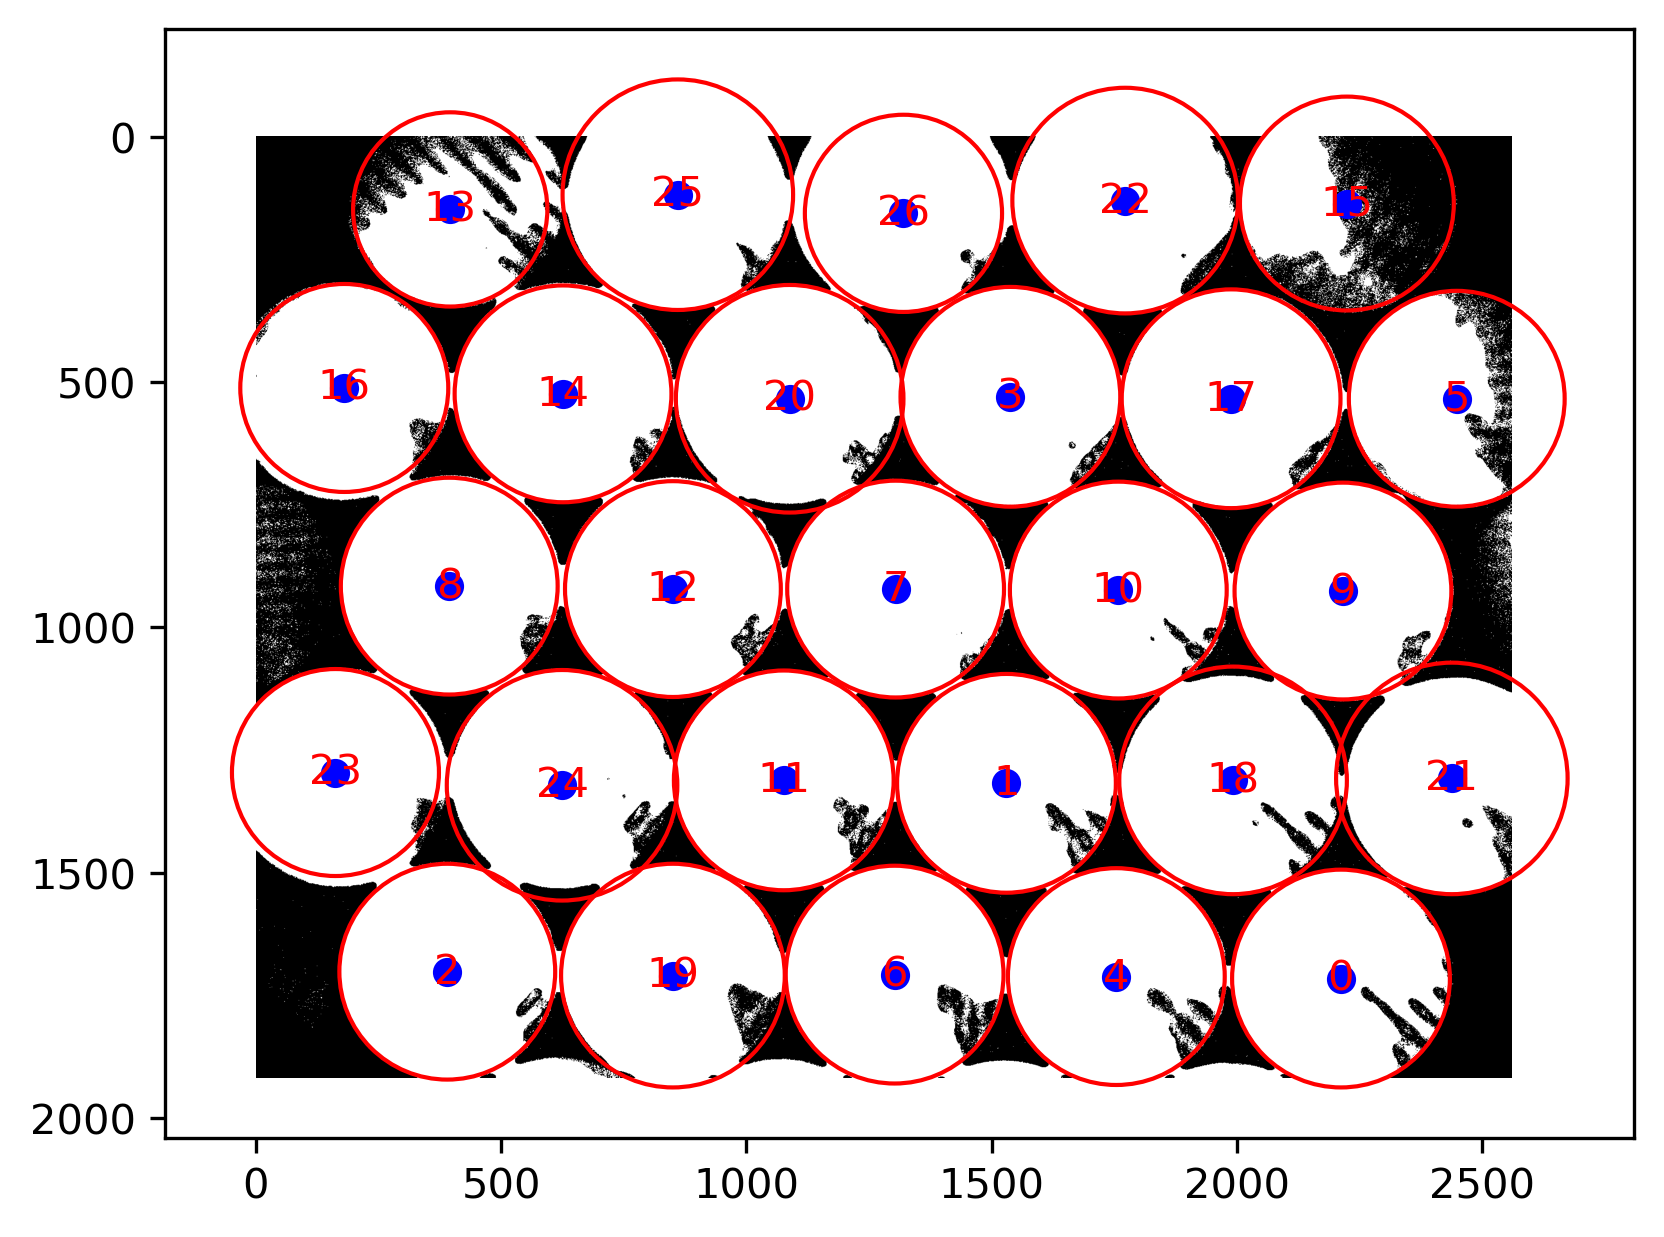

In [12]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.imshow(mask_img, cmap='gray')
for i in range(len(circles)):
    ax1.add_patch(plt.Circle((circles[i,0], circles[i,1]), circles[i,2], fill=False, color='r'))
    # Add the order of the circles in the center of each circle
    ax1.text(circles[i,0], circles[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')
    #plot the centers of the circles
    ax1.scatter(int(circles[i,0]), int(circles[i,1]), color = 'b')

2212 1716 2212 1716
1530 1318 2212 1716
390 1702 2212 1716
1538 530 2212 1716
1754 1712 2212 1716
2448 534 2212 1716
1302 1708 2212 1716
1304 922 2212 1716
394 916 2212 1716
2216 926 2212 1716
1758 924 2212 1716
1076 1312 2212 1716
850 922 2212 1716
396 148 2212 1716
626 524 2212 1716
2224 136 2212 1716
180 512 2212 1716
1988 534 2212 1716
1992 1312 2212 1716
850 1710 2212 1716
1088 534 2212 1716
2438 1308 2212 1716
1772 130 2212 1716
162 1296 2212 1716
624 1322 2212 1716
860 118 2212 1716
1320 156 2212 1716


C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_4180\734311775.py:9: RuntimeWarning: overflow encountered in scalar subtract
  distances.append(np.sqrt((circles[i,0]-circles[center_lenslet,0])**2 + (circles[i,1]-circles[center_lenslet,1])**2))
C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_4180\734311775.py:9: RuntimeWarning: invalid value encountered in sqrt
  distances.append(np.sqrt((circles[i,0]-circles[center_lenslet,0])**2 + (circles[i,1]-circles[center_lenslet,1])**2))


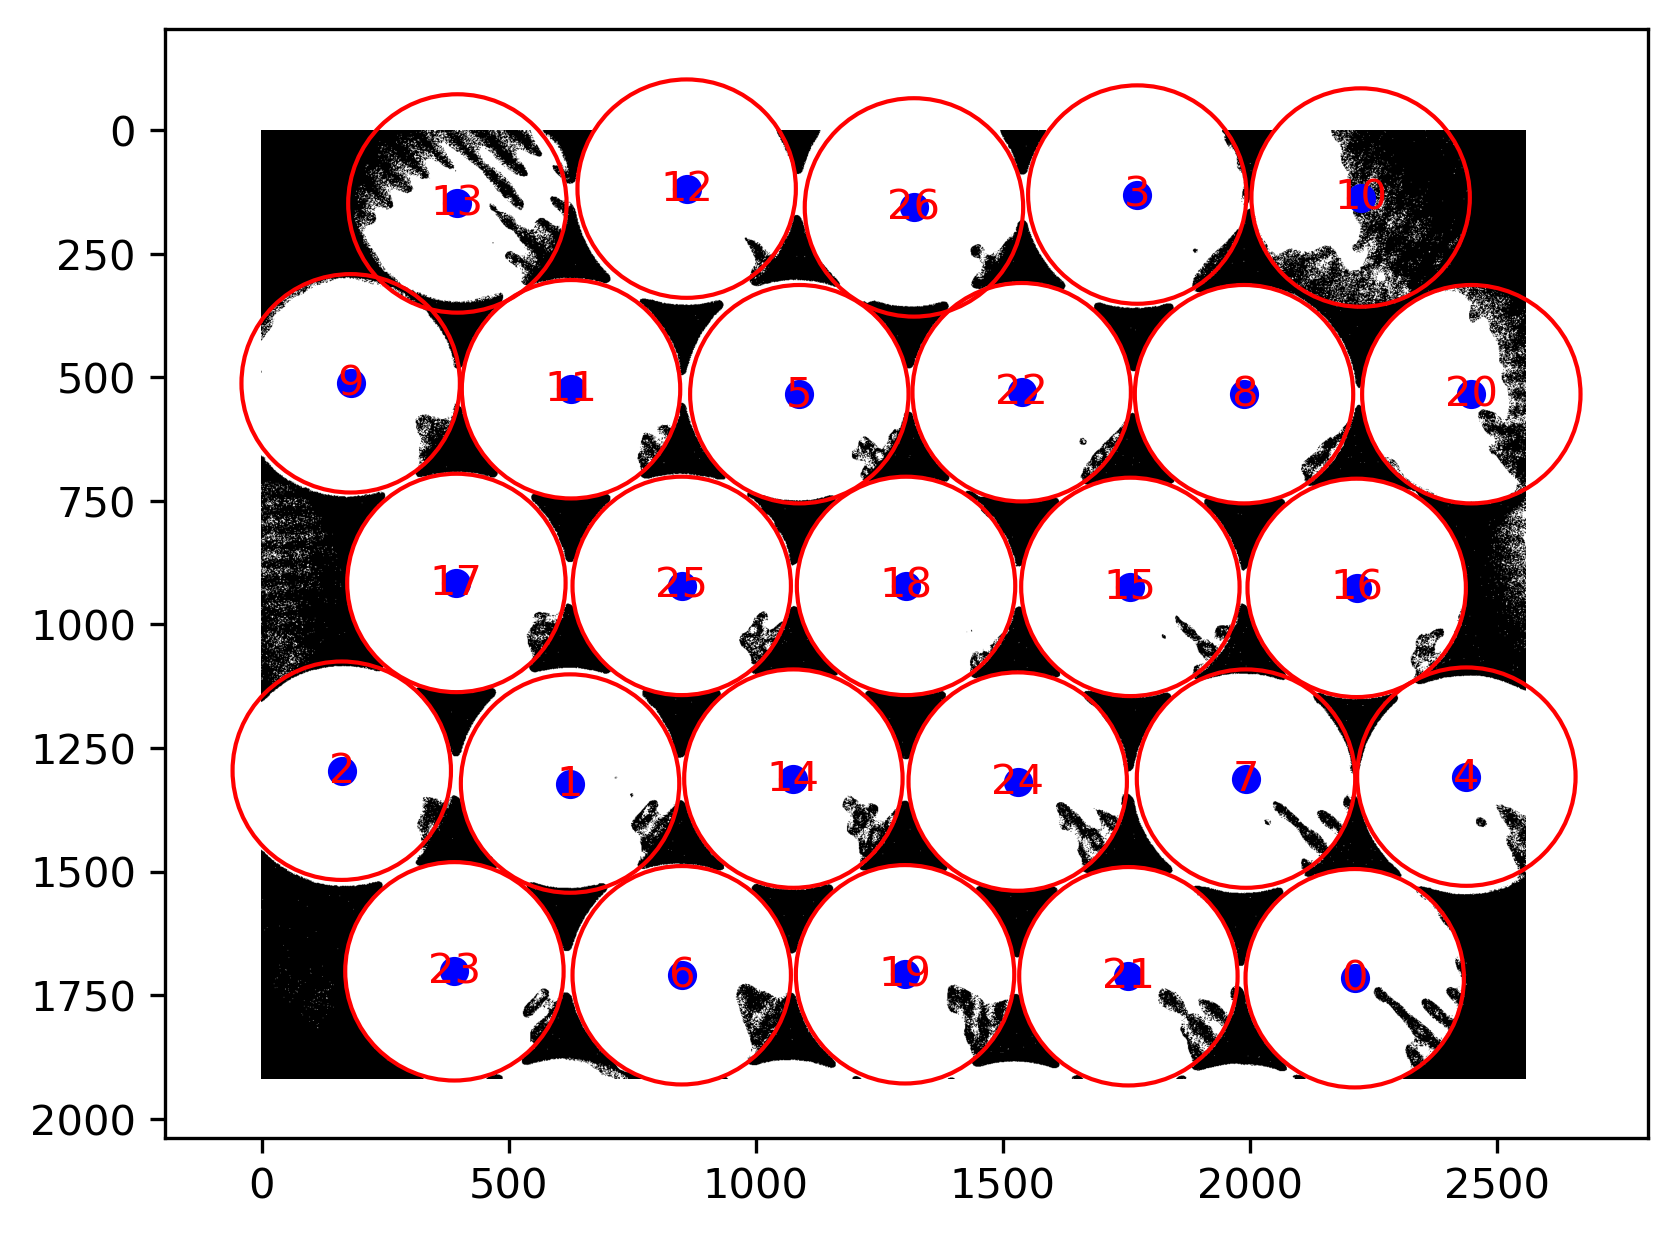

In [13]:
center_lenslet = int(0) # center circle index

# reorder the circles based on distance from the center circle, and then angle

# Find the distance of each circle from the center circle
distances = []
for i in range(len(circles[:,0])):
    print(circles[i,0], circles[i,1], circles[center_lenslet,0], circles[center_lenslet,1])
    distances.append(np.sqrt((circles[i,0]-circles[center_lenslet,0])**2 + (circles[i,1]-circles[center_lenslet,1])**2))

# Sort the circles based on distance from the center circle
circles = circles[np.argsort(distances)]

# Make the radius of the all circles the average of all the radii
average_radius = np.mean(circles[:,2])
circles[:,2] = average_radius

# Plot the circles in the correct order
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.imshow(mask_img, cmap='gray')
for i in range(len(circles)):
    ax2.add_patch(plt.Circle((circles[i,0], circles[i,1]), circles[i,2], fill=False, color='r'))
    # Add the order of the circles in the center of each circle
    ax2.text(circles[i,0], circles[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')
    #plot the centers of the circles
    ax2.scatter(int(circles[i,0]), int(circles[i,1]), color = 'b')

In [14]:
print(circles)

[[2212 1716  221]
 [ 624 1322  221]
 [ 162 1296  221]
 [1772  130  221]
 [2438 1308  221]
 [1088  534  221]
 [ 850 1710  221]
 [1992 1312  221]
 [1988  534  221]
 [ 180  512  221]
 [2224  136  221]
 [ 626  524  221]
 [ 860  118  221]
 [ 396  148  221]
 [1076 1312  221]
 [1758  924  221]
 [2216  926  221]
 [ 394  916  221]
 [1304  922  221]
 [1302 1708  221]
 [2448  534  221]
 [1754 1712  221]
 [1538  530  221]
 [ 390 1702  221]
 [1530 1318  221]
 [ 850  922  221]
 [1320  156  221]]


In [32]:
def maskImg(circles, image):
    if image.dtype != torch.tensor:
        image = torch.tensor(image)
        
    if len(image.shape) == 3:
        print('Image might have multiple channels, only the first channel will be used; future version will allow multiple channels to be processed.')
        image = image.squeeze(0)
    
    def circ(x,y,r):
        return ((x**2 + y**2) < r**2).int()
    
    mask = torch.zeros(image.shape)
    
    x_1 = torch.arange(image.shape[0]).float()
    y_1 = torch.arange(image.shape[1]).float()
    x,y = torch.meshgrid(x_1, y_1, indexing = 'ij')
    
    for i in range(len(circles[:,0])):
        mask[:, :] += circ(y-circles[i,0], x-circles[i,1], circles[i,2])
    
    mask = torch.clamp(mask, max = 1)
    
    return_img = torch.mul(image, mask)
        
    return return_img, mask

In [10]:
lenslet_distances_og = np.zeros((len(circles[:,0]), len(circles[:,0])))
lenslet_angles = np.zeros((len(circles[:,0]), len(circles[:,0])))

# Find the distances between the lenset centers
for i in range(len(circles[:,0])):
    for j in range(len(circles[:,0])):
        lenslet_distances_og[i,j] = (np.sqrt((circles[i,0]-circles[j,0])**2 + (circles[i,1]-circles[j,1])**2))
        lenslet_angles[i,j] = np.arctan2(circles[i,1]-circles[j,1], circles[i,0]-circles[j,0])

# Grab the 2nd diagonal of the matrix
lenslet_distances = np.diagonal(lenslet_distances_og, offset = 1)
lenslet_angles = np.diagonal(lenslet_angles, offset = 1)
lenslet_distance_avg = np.mean(lenslet_distances)

C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_10508\1341109589.py:7: RuntimeWarning: overflow encountered in scalar subtract
  lenslet_distances_og[i,j] = (np.sqrt((circles[i,0]-circles[j,0])**2 + (circles[i,1]-circles[j,1])**2))
C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_10508\1341109589.py:7: RuntimeWarning: invalid value encountered in sqrt
  lenslet_distances_og[i,j] = (np.sqrt((circles[i,0]-circles[j,0])**2 + (circles[i,1]-circles[j,1])**2))
C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_10508\1341109589.py:8: RuntimeWarning: overflow encountered in scalar subtract
  lenslet_angles[i,j] = np.arctan2(circles[i,1]-circles[j,1], circles[i,0]-circles[j,0])


In [11]:
lenslet_circle_mask = np.zeros((int(2*circles[0,2]+1),int(2*circles[0,2]+1)))

# Create a circular mask that has 0s outside the circle and 1s inside the circle
for i in range(int(2*circles[0,2]+1)):
    r = circles[0,2]
    for j in range(int(2*circles[0,2]+1)):
        
        if np.sqrt((i-r)**2 + (j-r)**2) <= r: # Assuming the radius of the first circle is the same as the rest
            lenslet_circle_mask[i,j] = 1
        else:
            lenslet_circle_mask[i,j] = 0

mask_tensor = torch.from_numpy(lenslet_circle_mask)

In [12]:
perspectives = torch.zeros(int(len(frames)), int(len(circles[:,0])) , int(2*circles[0,2]+1), int(2*circles[0,2]+1)) # Making the different perspectives te "channels", also the frames are always odd numbers
# The first dimension is the frame number, the second dimension is the lenslet number, the third and fourth dimensions are the x and y dimensions of the lenslet

for i in range(len(frames)):
    for j in range(len(circles[:,0])):
        placeholder = torch.Tensor(frames[i][int(circles[j,1]-circles[j,2]):int(circles[j,1]+circles[j,2]), int(circles[j,0]-circles[j,2]):int(circles[j,0]+circles[j,2])]) # Don't know why x and y are switched
        
        if placeholder.shape == perspectives[0,0,:,:].shape:
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:]
            
        else:
            # If the circle is too close to the edge of the image, we need to pad it
            placeholder_x_deficit = int(2*circles[j,2]+1) - placeholder.shape[0]
            placeholder_y_deficit = int(2*circles[j,2]+1) - placeholder.shape[1]
            
            if placeholder_x_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
            if placeholder_x_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
                
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:] # This is the same as the placeholder, but padded with zeros if the circle is too close to the edge of the image

C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_10508\2243801394.py:6: RuntimeWarning: overflow encountered in scalar subtract
  placeholder = torch.Tensor(frames[i][int(circles[j,1]-circles[j,2]):int(circles[j,1]+circles[j,2]), int(circles[j,0]-circles[j,2]):int(circles[j,0]+circles[j,2])]) # Don't know why x and y are switched


In [13]:
# Set-up Specific Constants
grid_Type = "hex"

NA = 0.4
fobj = 10000
f1 = 1
f2 = 1
fm = np.array([47000])

mla2sensor = 47000 # microns
lenspitch = 2520 # Lens pitch in microns 
pixel_size = 3.54 # Also referred to as pixel pitch in microns/px
refractive_index = 1 # Refractive index of the medium
wavelength = 0.5530

noLensHoriz = 3
noLensVert = 3

spacingPixels = 777
horizOffset = 1269
vertOffset = 690

shiftRow = 0
gridRot = 0

In [14]:
def FLFM_setCameraParams(config):
    # Config should be an array with the following parameters:
    # [NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot]
    
    objRad = config[0] * config[1] # Objective radius = NA * fobj
    k = 2 * np.pi * config[9] / config[8] # k = 2 * pi * refractive_index / wavelength (wave number)
    M = (config[4] * config[3]) / (config[2] * config[1]) # Magnification = fm * f2 / (f1 * fobj)
    d_refract = 3.5e-3 # Index of Refraction (__Don't know wherer the number came from__)
    fsRad = config[6] * config[3] / (2 * config[4]) # Field stop radius = lenspitch * f2 / (2 * fm)
    fovRad = fsRad / config[2]
    return [objRad, k, M, d_refract, fsRad, fovRad]

# Example: camera_params = FLFM_setCameraParams(config)

In [15]:
def resolution(camera_params, depth_step):
    # Find the number of pixels behind a lesnlet
    lenslet_pixels = [len(perspectives[0,0,0,:]), len(perspectives[0,0,:,0])]
    # Corresponding sensor resolution
    sensor_res = pixel_size
    object_res = [pixel_size/camera_params[2], pixel_size/camera_params[2], depth_step] # config[2] is the magnification
    fovRadVox = (camera_params[5] / i for i in object_res)  # Field of view radius in voxels
    return [lenslet_pixels, sensor_res, object_res, fovRadVox]

# example: res = resolution(camera_params, 10)

In [16]:
torch.save(perspectives, r'./perspectives.pt')

In [17]:
camera_params = FLFM_setCameraParams([NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot])
res = resolution(camera_params, 10)

In [18]:
def transmittance(wavenumber, lenslet_centers, calibration_img, focal_lengths, pixel_pitch):
    # Defining the local lenslet space
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    lenslet_pixels = 2*round(lenslet_centers[0,2])
    
    lenslet_pitch = pixel_pitch * lenslet_pixels # Supposedly the lenslet pitch is 2x the radius of the lenslet
    
    NNum_half = (lenslet_pixels / 2) # Number of pixels in the numerator, assuming the lenslet is square
    xML = pixel_pitch * torch.arange(start=-NNum_half+1, end=NNum_half-1, step = 1, dtype = torch.float32) # x coordinates of the lenslet space
    yML = xML.clone() # y coordinates of the lenslet space in the same units as xML
    
    #ulens_transmittance = np.zeros((len(focal_lengths),len(xML),len(yML)), dtype = np.complex64) # [focal length, x, y]
    ulens_transmittance = torch.zeros([len(focal_lengths),len(xML),len(yML)], dtype = torch.complex64) # [focal length, x, y]
    # Indexing: [lenslet x, lenslet y, focal length]
    # Lenslet centers is saved as [lens no, [x,y,r]]
    # We already have the distances between the lenslets, so we need to find the correct index for the x norm and y norm

    distance = (torch.pow(xML.tile((len(xML),1)),2) + torch.pow(yML.reshape(-1,1).tile((1,len(yML))),2))
    #distance = distance.numpy()

    condition = (distance < (lenslet_pitch/2)**2) # Condition for the lenslet transmittance, is 1 inside the lenslet and 0 outside the lenslet
    #condition.dtype
    condition = condition.to(torch.complex64)
    distance = distance.to(torch.complex64)
    #print(distance_squared)
    
    exp_workaround = (-0.5 * distance * wavenumber / focal_lengths[0]).to(torch.complex64)
    mul_test = torch.mul(torch.tensor(1j)*torch.sin(exp_workaround) + torch.cos(exp_workaround), condition)
    #print(torch.angle(torch.tensor(1j)*torch.sin(exp_workaround) + torch.cos(exp_workaround)))

    #exp_workaround = np.multiply(-0.5j * wavenumber / focal_lengths[0] , distance).astype(np.complex64)
    
    for c in range(len(focal_lengths)):
        ulens_transmittance[c,:,:] = torch.mul(torch.cos(exp_workaround) + torch.tensor(1j, dtype = torch.complex64) * torch.sin(exp_workaround), condition) # Exp seems to not work properly, so I'm using cos and sin instead #+ torch.mul(torch.tensor(1j), test)
        ulens_transmittance = torch.mul((ulens_transmittance[c,:,:]), condition).unsqueeze(0)
        
    #ulens_transmittance = torch.from_numpy(ulens_transmittance)

    # lenslet_centers_tensor is a tensor that has 1s where the lenslet centers are and 0s everywhere else
    lenslet_centers_tensor = torch.zeros((len(calibration_img[0,:]), len(calibration_img[:,0])), dtype=torch.complex64).unsqueeze(0).unsqueeze(0).to(device) # [0,0,x,y]
    
    #lenslet_centers_tensor[0,0,lenslet_centers[:,0],lenslet_centers[:,1]] = 1

    ulens_transmittance = ulens_transmittance.unsqueeze(0).to(device)# [0,focal length,x,y]
    
    for i in range(len(lenslet_centers[:,0])):
        # Grab a kernel sized chunk of the lenslet centers tensor, but don't go out of bounds. Instead, pad with zeros
        #lenslet_center_x = lenslet_distances_norm[i,0] + np.ceil((lenslet_centers_tensor.shape[2] +1) /2) # The center of the lenslet in the lenslet space
        #lenslet_center_y = lenslet_distances_norm[i,1] + np.ceil((lenslet_centers_tensor.shape[3] +1) /2) # The center of the lenslet in the lenslet space
        
        lenslet_center_x = lenslet_centers[i,0] #+ np.ceil((lenslet_centers_tensor.shape[2] +1) /2) # The center of the lenslet in the lenslet space
        lenslet_center_y = lenslet_centers[i,1] #+ np.ceil((lenslet_centers_tensor.shape[3] +1) /2) # The center of the lenslet in the lenslet space
            
        grab_x_start = int(lenslet_center_x - np.ceil((ulens_transmittance.shape[2] +1) /2))
        grab_y_start = int(lenslet_center_y - np.ceil((ulens_transmittance.shape[3] +1) /2))
        grab_x_end = int(lenslet_center_x + np.floor((ulens_transmittance.shape[2] -1) /2))
        grab_y_end = int(lenslet_center_y + np.floor((ulens_transmittance.shape[3] -1) /2))
        
        pull_x_start = int(0)
        pull_y_start = int(0)
        pull_x_end = int(ulens_transmittance.shape[2])
        pull_y_end = int(ulens_transmittance.shape[3])
        
        if grab_x_start < 0:
            pull_x_start = int(abs(2*grab_x_start-1)/2)
            grab_x_start = int(0)
        if grab_y_start < 0:
            pull_y_start = int(abs(2*grab_y_start-1)/2)
            grab_y_start = int(0)
        if grab_x_end > int(lenslet_centers_tensor.shape[2]):
            grab_x_end = int(lenslet_centers_tensor.shape[2])
            pull_x_end = int((2*(grab_x_end - grab_x_start)+1)/2)
        if grab_y_end > int(lenslet_centers_tensor.shape[3]):
            grab_y_end = int(lenslet_centers_tensor.shape[3])
            pull_y_end = int((2*(grab_y_end - grab_y_start)+1)/2)
        
        lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end] = ulens_transmittance[:,:,pull_x_start:pull_x_end,pull_y_start:pull_y_end]

    return lenslet_centers_tensor, ulens_transmittance

In [19]:
ulens_transmit, single_lens_transmittance = transmittance(camera_params[1], circles, mask_img, fm, pixel_size)

In [20]:
# Properties that I do not know and I will just use the values in the code
proportion = 3
LU0 = 2500  # microns, physical length of the of sampled input at the NOP
N_calcPSF = 7999  # Resolution of the point spread function

In [21]:
def psfCalc(fobj, k, NA, calibration_img, pixel_pitch, wavelength, n, depths):
    # Feed in depths as a list of depths
    
    device = "cpu"
    
    #if torch.cuda.is_available():
    #    device = torch.device("cuda:0")
    #else:
    #    device = torch.device("cpu")
    
    sensor_spatial = [int(len(calibration_img[:,0]) * pixel_pitch /2 ), int(len(calibration_img[0,:]) * pixel_pitch /2 )]# sensor size (in micron) = pixel size (in micron/px) * sensor size (in px)
    sensor_size = [int(len(calibration_img[:,0])), int(len(calibration_img[0,:]))] # sensor size in pixels
    
    # fobj = objective focal length
    # k = wave number
    # NA = objective numerical aperture
    # sensor_size = size of the sensor in microns, calculated from the calibration image size and the pixel size, sensor size (in micron) = pixel size (in micron/px) * sensor size (in px)
    # d = lenslet pitch
    # n = refractive index
    # n_step = number of steps in the z direction
    
    # phase delay suffered by the rays is the optical path difference (WHy are we calculating this?)
    #if n != n_step:
        #theta_half = theta / 2
       # diff = (d / config[8]) * (n-n_step) * (1 + 2*n / n_step * np.sin(theta_half)^2 + 2*(n+n_step) * (n**2) / (n_step**3) * np.sin(theta_half)^4)
    #else:
       #diff = 0
        
    # Now we simulate the propagation of the rays to the sensor plane
    
    amp = 1000 # Normalized amplitude of the rays
    mid = int((N_calcPSF+1)/2) # Where the delta function is located, N_calcPSF is always odd
    NOP_x = torch.linspace(-LU0/2, LU0/2, N_calcPSF, dtype = torch.float32).to(device) # x coordinates of the NOP plane
    NOP_y = NOP_x.clone() # y coordinates of the NOP plane, we assume the NOP is square
    x, y = torch.meshgrid(NOP_x, NOP_y, indexing = 'ij') # Meshgrid of the NOP
    
    scale_factor = max(sensor_size)/ N_calcPSF # Scale factor to account for the difference in the size of the sensor and the size of the PSF

    psf_sensor = torch.zeros(len(depths), sensor_size[0], sensor_size[1]).to(device).to(torch.complex64) # Initialize the PSF with the sensor size
    
    dobj = 2 * NA * fobj # Diameter of the objective
    M_relay = f2 / f1 # Relay magnification
    
    def circ(x, y, r):
        return (x**2 + y**2 < r**2).to(int)
    
    # We note that the PSF is shift-invariant, so we can calculate the PSF at the origin
    for i in range(len(depths)):
        if depths[i] == 0:
            depths[i] = 1e-8 # To avoid division by 0
        
        r = torch.div(torch.sqrt(torch.pow(x,2) + torch.pow(y,2) + torch.pow(depths[i], 2)),n) # Distance from the origin to the sensor plane
        
        if depths[i] > 0:
            r = -r # To propogate to the lens
        
        U0 = torch.mul(torch.div(amp * k * torch.tensor([-1j], dtype = torch.complex64, device=device),r),torch.exp(torch.mul(k*torch.tensor([1j], dtype = torch.complex64,device = device), r))) / (2 * torch.pi)

        source_sample_rate = LU0 / len(U0) # Sampling rate of the input field
        U1 = torch.mul(torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(U0))), source_sample_rate**2).to(dtype=torch.complex64) # Propogate to the sensor plane, with a scaling factor to account for the sampling
        coeffU1 = torch.tensor([-1j], dtype = torch.complex64,device=device) * torch.exp(k * fobj * torch.tensor([1j], dtype = torch.complex64, device = device)) / wavelength / fobj
        U1 = torch.mul(coeffU1, U1)
        
        LU1 = wavelength * fobj / source_sample_rate # Physical length of the sampled input field at the sensor plane
        
        U1 = torch.mul(U1, circ(x*LU1/LU0, y*LU1/LU0, dobj/2)) # Multiply the PSF by the circle mask
        
        cut = [round(sensor_spatial[0] * (N_calcPSF + 1) / (2 * (M_relay * LU1))), round(sensor_spatial[1] * (N_calcPSF + 1) / (2 * M_relay * LU1))]
        
        U1 = U1[mid-cut[0]:mid+cut[0], mid-cut[1]:mid+cut[1]].unsqueeze(0).unsqueeze(0) # Cut the PSF to the correct size
        
        U1_real_resize = transforms.Resize(size = sensor_size , interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(torch.real(U1)) # Resize the PSF to the sensor size
        U1_imag_resize = transforms.Resize(size = sensor_size , interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(torch.imag(U1)) # Resize the PSF to the sensor size
        U1 = torch.complex(U1_real_resize, U1_imag_resize)
        del U1_real_resize, U1_imag_resize
        
        U1 = U1.squeeze(0).squeeze(0)
        
        # When PSF is smaller than the sensor, we need to index the sensor space to the correct location
        if len(U1[:,0]) < sensor_size[0]:
            push_x_start = 0
            push_x_end = len(U1[:,0])
            pull_x_start = int((sensor_size[0] - len(U1[:,0]))/2)
            pull_x_end = int((sensor_size[0] + len(U1[:,0]))/2)
        
        if len(U1[0,:]) < sensor_size[1]:
            push_y_start = 0
            push_y_end = len(U1[0,:])
            pull_y_start = int((sensor_size[1] - len(U1[0,:]))/2)
            pull_y_end = int((sensor_size[1] + len(U1[0,:]))/2)
        
        # When the PSF is bigger than the sensor, we need to crop the psf
        if len(U1[:,0]) >= sensor_size[0]:
            push_x_start = int((len(U1[:,0])-sensor_size[0])/2)
            push_x_end = int((len(U1[:,0])+sensor_size[0])/2)
            pull_x_start = int(0)
            pull_x_end = int(sensor_size[0])
        
        if len(U1[0,:]) >= sensor_size[1]:
            push_y_start = int((len(U1[0,:])-sensor_size[1])/2)
            push_y_end = int((len(U1[0,:])+sensor_size[1])/2)
            pull_y_start = int(0)
            pull_y_end = int(sensor_size[1])

        psf_sensor[i, pull_x_start:pull_x_end, pull_y_start:pull_y_end] = U1[push_x_start:push_x_end, push_y_start:push_y_end]
        #psf_sensor[i,:,:] = transforms.Resize(size = sensor_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(psf)[0,0,:,:] # Resize the PSF to the sensor size
        
        del U0, r, cut
            
    # Shift the center of the PSF to the center of the center lenslet
    #psf_sensor = torch.roll(psf_sensor, shifts= (-int(lenslet_centers[center_lenslet, 0] - (sensor_size[0]/2)), -int(lenslet_centers[center_lenslet, 1] - (sensor_size[1]/2))), dims = (2,1))
        
    return psf_sensor

In [22]:
depths = torch.linspace(-100, 100, 20) # Depths in microns, 10 microns is the increment between depths
psfStack = psfCalc(fobj, camera_params[1], NA, mask_img, pixel_size, wavelength, refractive_index, depths) # CPU usage is at 100% when running this. GPU would be better.
torch.save(psfStack, './psfStack_pdh.pt')

In [213]:
def LFPSF(psfStack, calibration_image, pixel_size, mla2sensor, wavelength, ulens_transmittance, depths, device, path, save_psf = False):
    
    # psfStack is in the format [depth, x, y]
    
    if device == "cuda":
        print(torch.cuda.is_available())
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    elif device == "cpu":
        device = torch.device("cpu")
    elif device == "mps":
        print("MPS may have unforeseen consequences...")
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    else:
        print("Device not recognized, using CPU")
        device = torch.device("cpu")
    
    ulens_transmittance = ulens_transmittance.to(device)

    forward = np.empty( (len(calibration_image[:,0]), len(calibration_image[0,:]), len(psfStack[:,0,0]))).astype(np.complex64)
    backward = np.empty( (len(calibration_image[0,:]), len(calibration_image[:,0]), len(depths))).astype(np.float32)
    
    Nx = len(psfStack[0,:,0])
    Ny = len(psfStack[0,0,:])
    k = 2 * torch.pi / wavelength
    
    du = torch.div(1, (Nx * pixel_size))
    dv = torch.div(1, (Ny * pixel_size))
    u = torch.concatenate((torch.arange(0, np.ceil(Nx/2)), torch.arange(np.ceil(-Nx/2), 0))).to(device) * du
    v = torch.concatenate((torch.arange(0, np.ceil(Ny/2)), torch.arange(np.ceil(-Ny/2), 0))).to(device) * dv
    
    u = u.cpu().numpy().astype(complex) # Exp workaround; pytorch gives false values for the exp function
    v = v.cpu().numpy().astype(complex) # Exp workaround; pytorch gives false values for the exp function
    
    H = np.exp(1j * mla2sensor * k * np.emath.sqrt(1 - (wavelength**2) * (np.power(np.tile(u.reshape(-1, 1),(1, len(v))), 2) + np.power(np.tile(v,(len(u),1)), 2)))) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    #exp_workaround_1 = mla2sensor * k * torch.sqrt(1 - (wavelength**2) * (torch.pow(u.reshape(-1, 1).repeat(1, len(v)), 2) + torch.pow(v.repeat(len(u),1), 2)))
    #H = torch.cos(exp_workaround_1) + torch.mul(torch.tensor(1j), torch.sin(exp_workaround_1)) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    #H = torch.exp(torch.tensor(1j, dtype=torch.complex64, device=device) * mla2sensor * k * torch.sqrt((1 - (wavelength**2) * mla2sensor * k * (torch.pow(u.reshape(-1, 1).repeat(1, len(v)), 2) + torch.pow(v.repeat(len(u),1), 2))).to(torch.complex64))) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    
    for i in range(len(psfStack[:,0,0])):
        psfMLA = torch.mul(psfStack[i,:,:].to(device), torch.permute(ulens_transmittance[0,0,:,:].to(device).squeeze(0), (1,0)).squeeze(0)).cpu().numpy().astype(complex) # Multiply the PSF by the transmittance function
        #exp_workaround2 = torch.cos(torch.tensor(k * mla2sensor)) + torch.mul(torch.tensor(1j), torch.sin(torch.tensor(k * mla2sensor)))
        forward[:,:,i] = np.abs(np.emath.power(np.exp(1j * mla2sensor * k) * np.fft.ifft2(np.multiply(np.fft.fft2(psfMLA),H)), 2))
        #forward[:,:,i] = torch.abs(torch.pow(torch.exp(1j*  mla2sensor * k * torch.sqrt(1 - (wavelength**2) * (torch.pow(u.reshape(-1, 1).repeat(1, len(v)), 2) + torch.pow(v.repeat(len(u),1), 2)))) * (torch.fft.ifft2(torch.mul(torch.fft.fft2(psfMLA),H))) ,2))
        #forward[:,:,i] = torch.abs(torch.pow(exp_workaround2 * (torch.fft.ifft2(torch.mul(torch.fft.fft2(psfMLA),H))) ,2))
    
    forward = torch.from_numpy(forward.astype(np.float32))
    backward = forward.clone()
    
    # Side note
    # 1. The backward model is the same as the forward model, so transpose results afterwards.
    # 2. Scaling and normalizing should be done cleverly, as the floating point numbers become very small and creatte numerical instability (i.e. negative numbers, NaNs, etc.)
    
    return forward, backward, psfMLA

In [214]:
save_path = r"./"

In [215]:
print(psfStack.shape)

torch.Size([20, 1920, 2560])


In [216]:
forward_test, backward_test, h = LFPSF(psfStack[:,:,:], mask_img, pixel_size, mla2sensor, wavelength, ulens_transmit, depths, "cpu", save_path, True) # This would be a great place to use multiprocessing/multithreading.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/var/folders/tw/r7vzypfs02q87460_njpb5wm0000gn/T/ipykernel_60884/1623258204.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  forward = torch.from_numpy(forward.astype(np.float32))


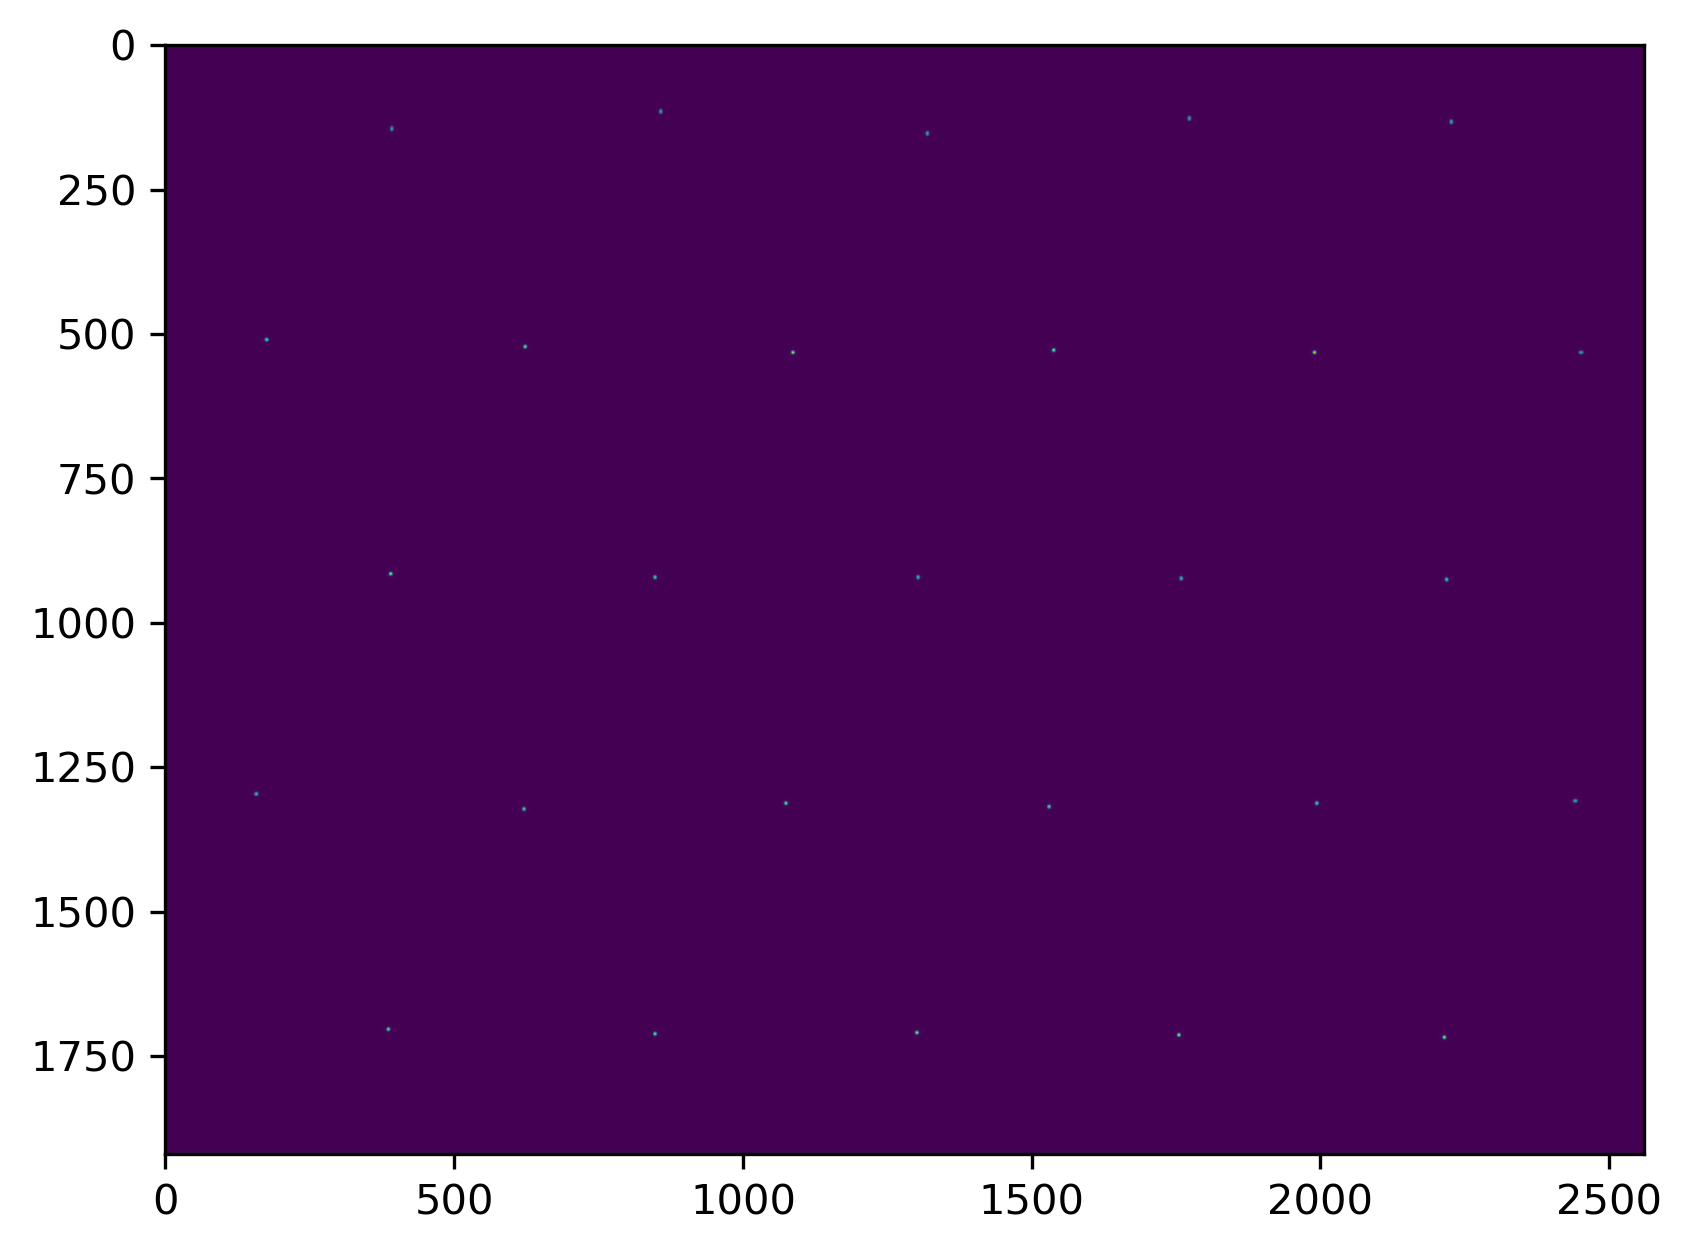

In [219]:
plt.imshow(forward_test[:,:,12])

In [220]:
torch.save(forward_test, save_path + "forward_test_pdh.pt")
torch.save(backward_test, save_path + "backward_test_pdh.pt")

# Forward and Backward normalization

In [2]:
import torch

In [3]:
def f_b_norm(forward, backward, path):
    # Normalize so that the each forward depth slice sums to 1
    forward[:,:,:] = torch.div(forward[:,:,:], torch.sum(forward, dim = (1,2)).unsqueeze(1).unsqueeze(2)) # Brodcast the sum of the forward model to the same shape as the forward model
    forward[torch.logical_and(forward>=0, forward<=1e-6)] = 0 
    forward[:,:,:] = torch.div(forward[:,:,:], torch.sum(forward, dim = (1,2,)).unsqueeze(1).unsqueeze(2)) # Brodcast the sum of the forward model to the same shape as the forward model
    
    # Normalize so that each voxel for the backward model sums to 1
    backward[:,:,:] = torch.div(backward[:,:,:], torch.sum(backward, dim = (0)).unsqueeze(0)) # Brodcast the sum of the backward model to the same shape as the backward model
    backward[torch.logical_and(backward>=0, backward<=1e-6)] = 0
    backward[:,:,:] = torch.div(backward[:,:,:], torch.sum(backward, dim = (0)).unsqueeze(0)) # Brodcast the sum of the backward model to the same shape as the backward model
    
    # Save the normalized forward and backward models
    torch.save(forward, path + "forward_norm.pt")
    torch.save(backward, path + "backward_norm.pt")
    
    return None # This function is only used to save the normalized forward and backward models

In [7]:
path = "/Users/halensolomon/Code/FLFM_local/pyFLFM"

In [8]:
norm = f_b_norm(torch.load(path + '/forward_test_pdh.pt'), torch.load(path + '/backward_test_pdh.pt'), path) # This would be a great place to use multiprocessing/multithreading.

In [225]:
torch.save(frames, r'./frames.pt')

In [ ]:
torch.save(torch.load())

# Mask to FOV

In [23]:
def maskFOV(tensor, fov_radius):
    def circ(x, y, r):
            return (x**2 + y**2 < r**2).to(int)
            
    if len(tensor.shape) == 2:
        tensor = tensor.unsqueeze(0)
        
    x_1 = torch.linspace(int(-tensor.shape[1]/2), int(tensor.shape[1]/2), tensor.shape[0])
    y_1 = torch.linspace(int(-tensor.shape[2]/2), int(tensor.shape[2]/2), tensor.shape[1])
    x, y = torch.meshgrid(x_1, y_1)
    
    return_tensor = torch.mul(tensor, circ(x, y, fov_radius).unsqueeze(0))

    return return_tensor